# 로봇공학 실습 1주차
## open CV를 활용한 차선 인식

참고자료: https://m.blog.naver.com/windowsub0406/220892704332

코랩 환경에서는 cv2_imshow()로 이미지 출력

In [35]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

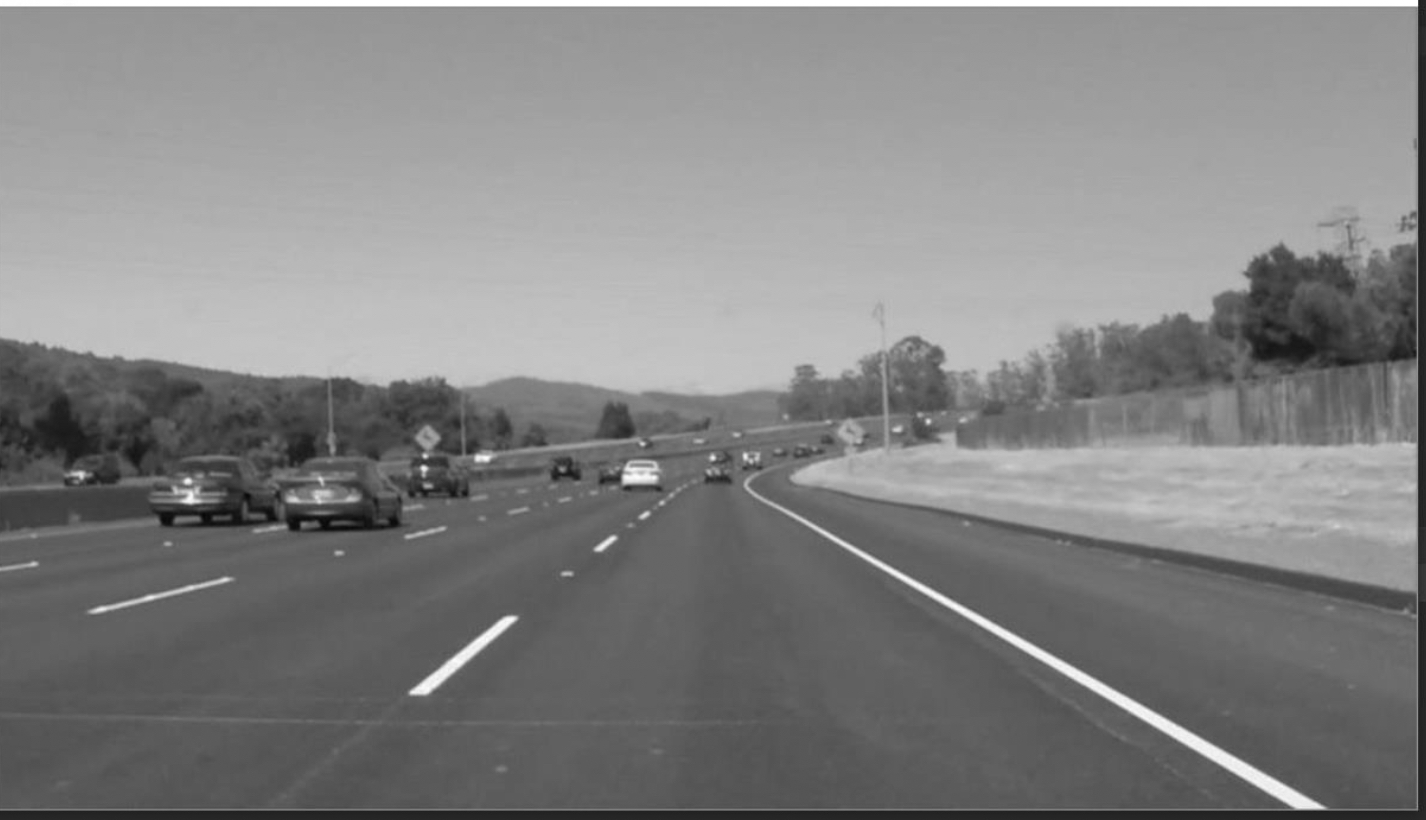

-1

In [36]:
path = '/content/road.jpg'

#GrayScale
gray_image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
cv2_imshow(gray_image)
cv2.waitKey(0)

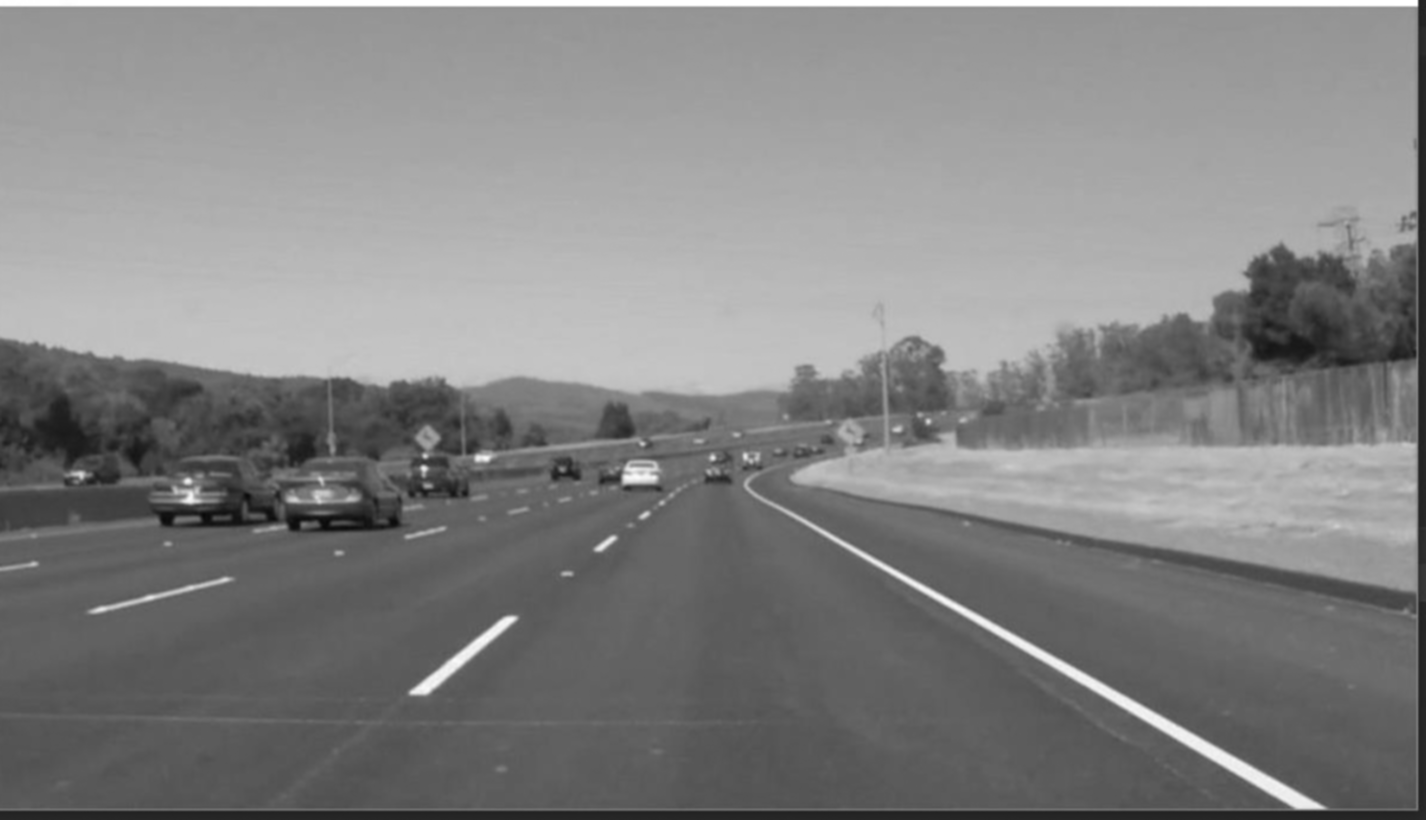

-1

In [37]:
#블러 처리

blur_image = cv2.GaussianBlur(gray_image,(3,3),0)
cv2_imshow(blur_image)
cv2.waitKey(0)

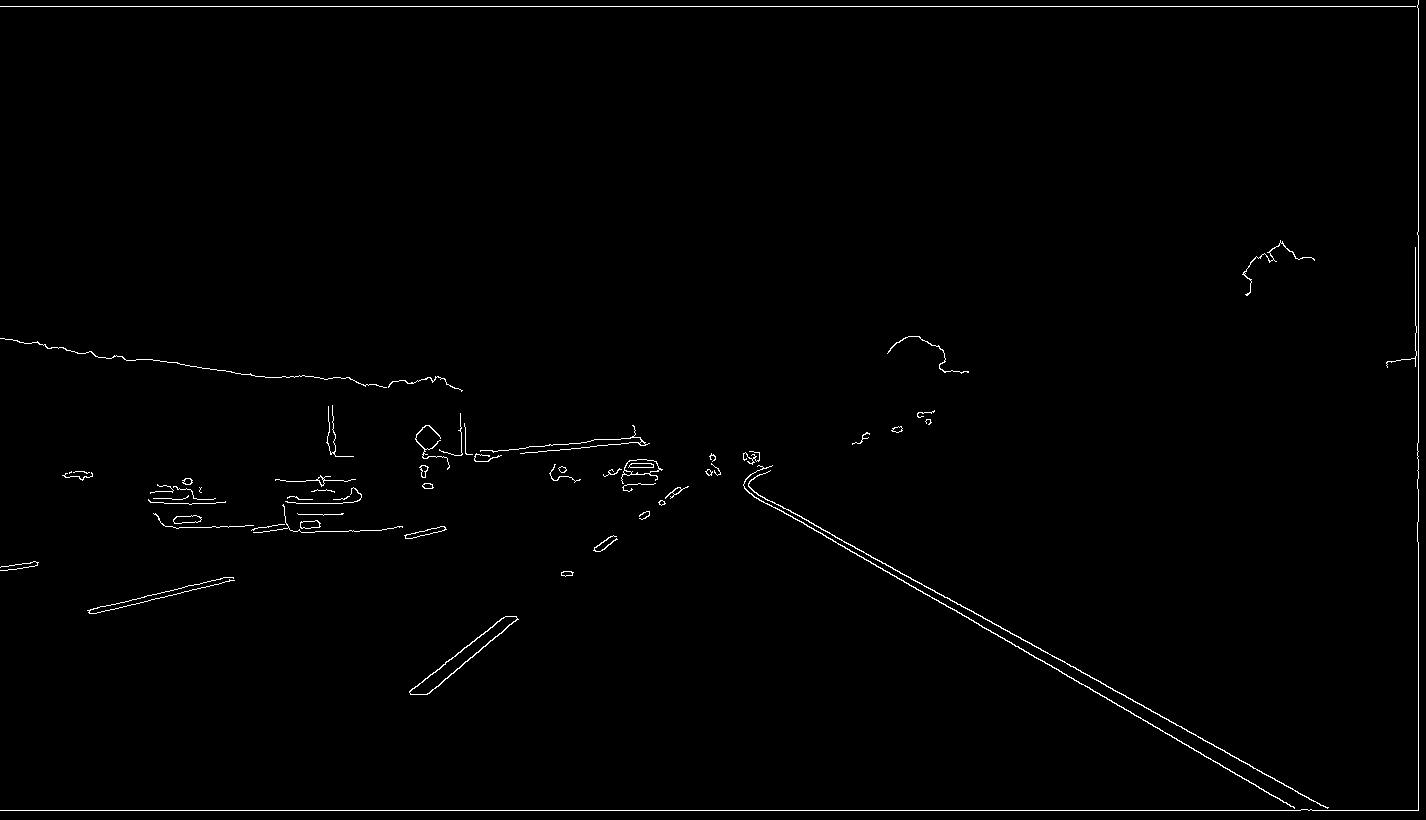

-1

In [38]:
canny_image = cv2.Canny(blur_image,70,210)
cv2_imshow(canny_image)
cv2.waitKey(0)

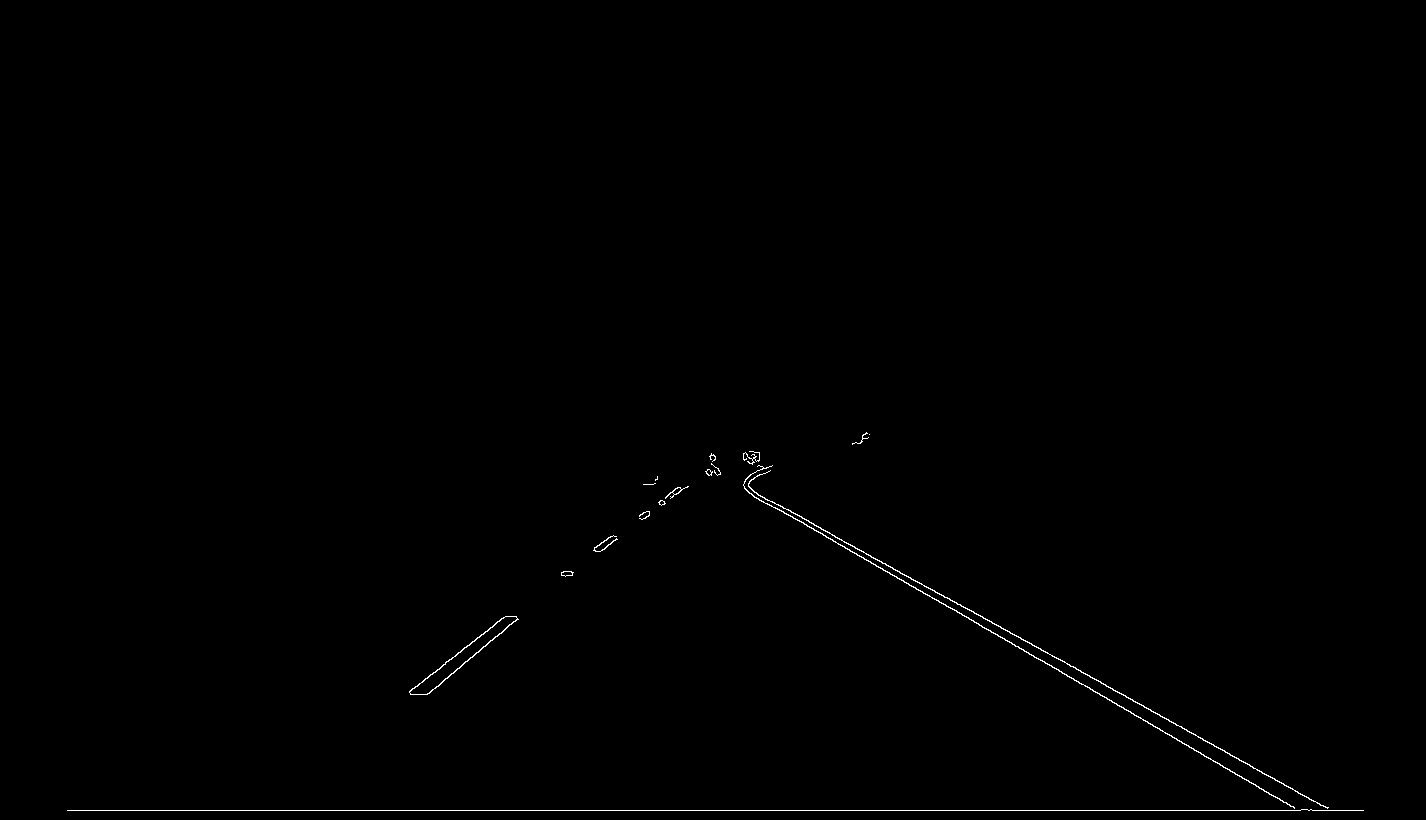

In [40]:
#ROI
def region_of_interest(img, vertices, color3=(255,255,255), color1=255): # ROI 셋팅

    mask = np.zeros_like(img) # mask = img와 같은 크기의 빈 이미지
    
    if len(img.shape) > 2: # Color 이미지(3채널)라면 :
        color = color3
    else: # 흑백 이미지(1채널)라면 :
        color = color1
        
    # vertices에 정한 점들로 이뤄진 다각형부분(ROI 설정부분)을 color로 채움 
    cv2.fillPoly(mask, vertices, color)
    
    # 이미지와 color로 채워진 ROI를 합침
    ROI_image = cv2.bitwise_and(img, mask)
    return ROI_image


image = cv2.imread(path)

height, width = image.shape[:2]
vertices = np.array([[(50,height),(width/2-45,height/2+60),(width/2+45,height/2-60),(width-50,height)]],dtype=np.int32)

ROI_img = region_of_interest(canny_image,vertices)

cv2_imshow(ROI_img)

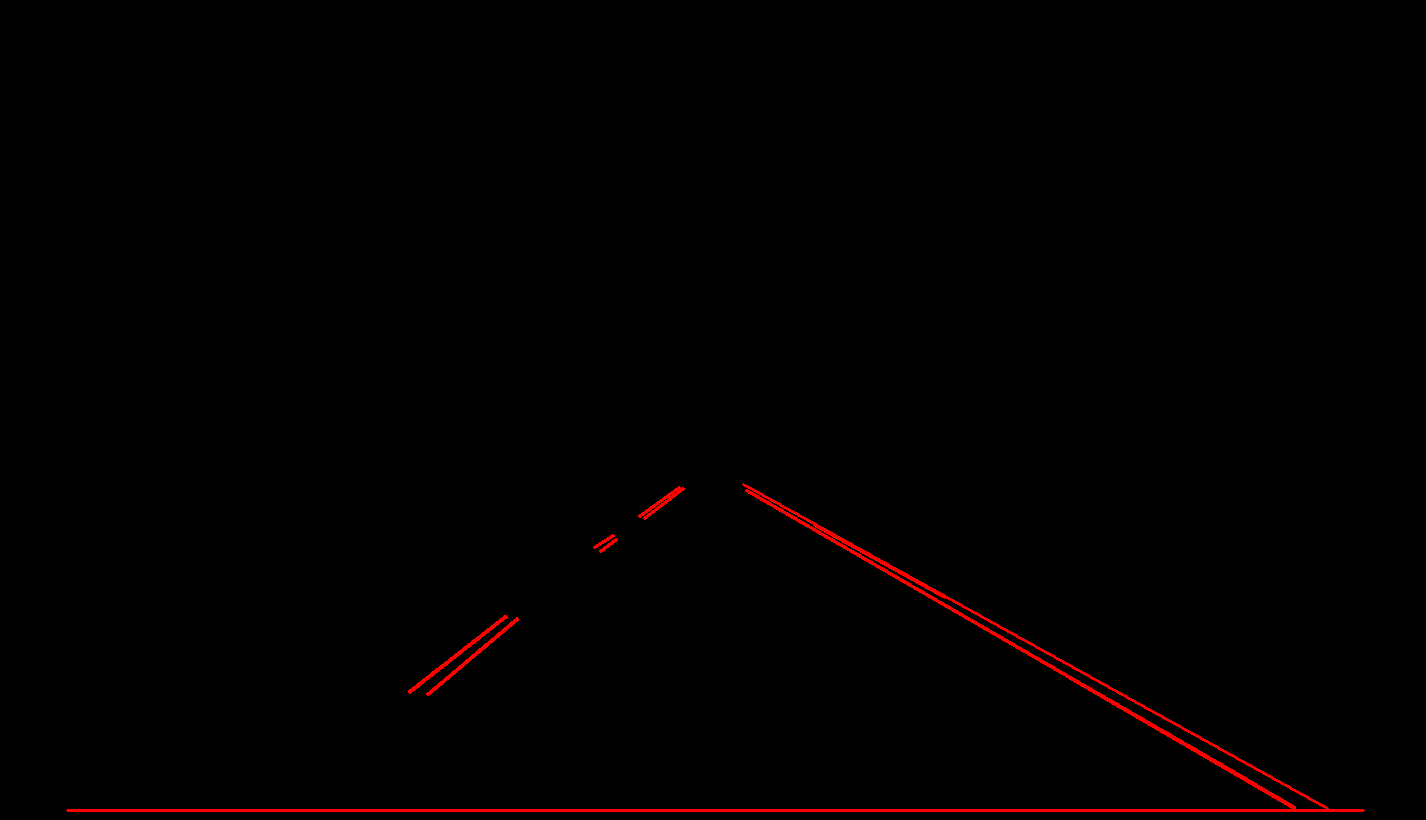

In [42]:
# Hough Transform

def draw_lines(img, lines, color=[0, 0, 255], thickness=2): # 선 그리기
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap): # 허프 변환
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)

    return line_img

hough_img = hough_lines(ROI_img, 1, 1 * np.pi/180, 30, 10, 20) # 허프 변환
cv2_imshow(hough_img)

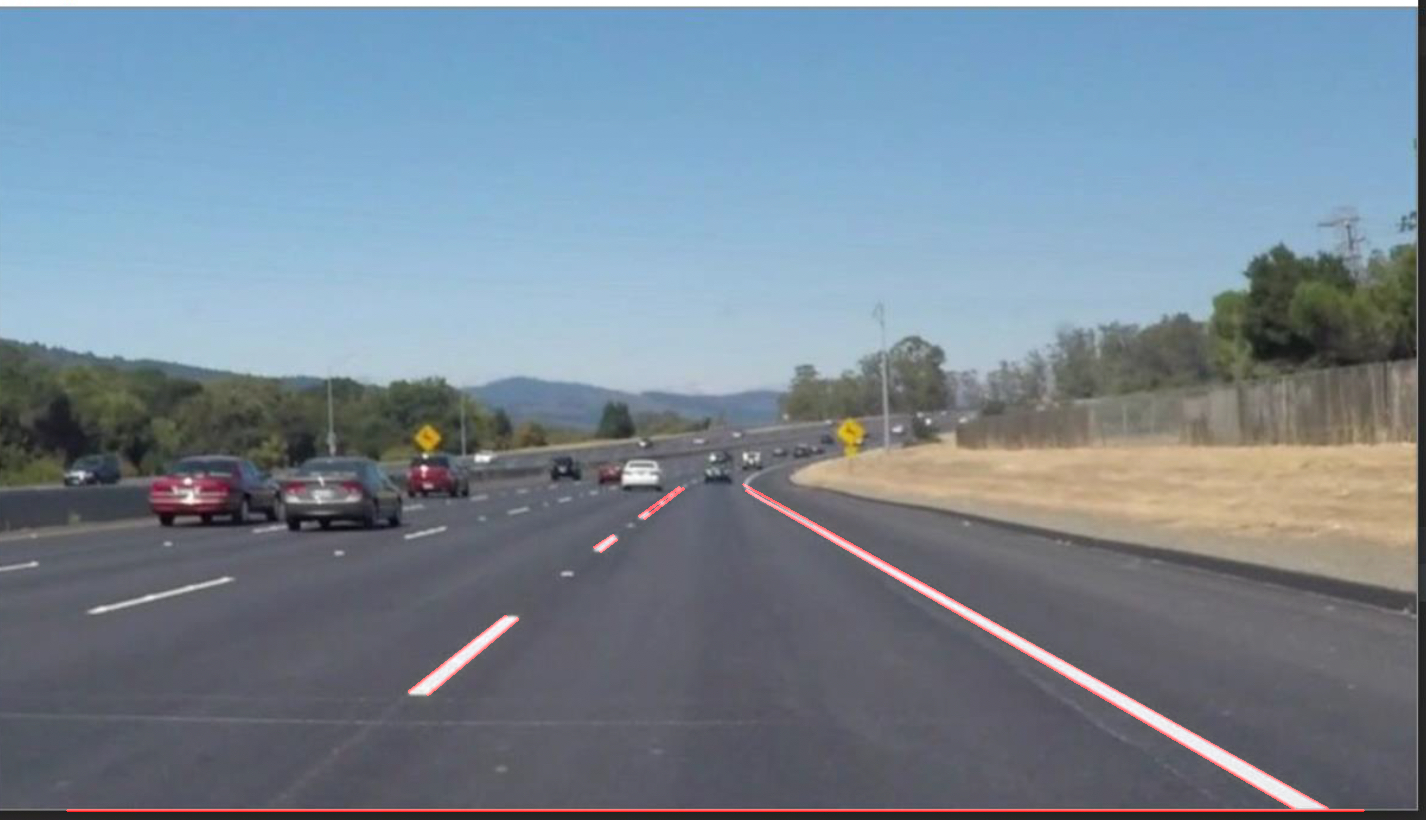

In [43]:
#결과

def weighted_img(img, initial_img, α=1, β=1., λ=0.): # 두 이미지 operlap 하기
    return cv2.addWeighted(initial_img, α, img, β, λ)

result = weighted_img(hough_img, image)
cv2_imshow(result)

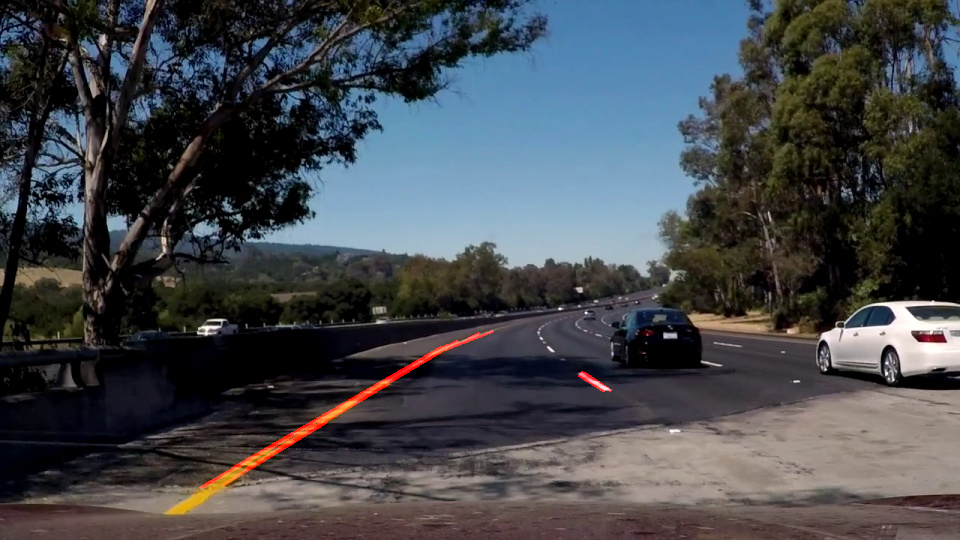

-1

In [46]:
# 후처리

def grayscale(img): # 흑백이미지로 변환
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold): # Canny 알고리즘
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size): # 가우시안 필터
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices, color3=(255,255,255), color1=255): # ROI 셋팅

    mask = np.zeros_like(img) # mask = img와 같은 크기의 빈 이미지
    
    if len(img.shape) > 2: # Color 이미지(3채널)라면 :
        color = color3
    else: # 흑백 이미지(1채널)라면 :
        color = color1
        
    # vertices에 정한 점들로 이뤄진 다각형부분(ROI 설정부분)을 color로 채움 
    cv2.fillPoly(mask, vertices, color)
    
    # 이미지와 color로 채워진 ROI를 합침
    ROI_image = cv2.bitwise_and(img, mask)
    return ROI_image

def draw_lines(img, lines, color=[0, 0, 255], thickness=2): # 선 그리기
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap): # 허프 변환
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)

    return lines

def weighted_img(img, initial_img, α=1, β=1., λ=0.): # 두 이미지 operlap 하기
    return cv2.addWeighted(initial_img, α, img, β, λ)

image = cv2.imread('/content/slope_test.jpg') # 이미지 읽기
height, width = image.shape[:2] # 이미지 높이, 너비

gray_img = grayscale(image) # 흑백이미지로 변환
    
blur_img = gaussian_blur(gray_img, 3) # Blur 효과
        
canny_img = canny(blur_img, 70, 210) # Canny edge 알고리즘

vertices = np.array([[(50,height),(width/2-45, height/2+60), (width/2+45, height/2+60), (width-50,height)]], dtype=np.int32)
ROI_img = region_of_interest(canny_img, vertices) # ROI 설정

line_arr = hough_lines(ROI_img, 1, 1 * np.pi/180, 30, 10, 20) # 허프 변환
line_arr = np.squeeze(line_arr)
    
# 기울기 구하기
slope_degree = (np.arctan2(line_arr[:,1] - line_arr[:,3], line_arr[:,0] - line_arr[:,2]) * 180) / np.pi

# 수평 기울기 제한
line_arr = line_arr[np.abs(slope_degree)<160]
slope_degree = slope_degree[np.abs(slope_degree)<160]
# 수직 기울기 제한
line_arr = line_arr[np.abs(slope_degree)>95]
slope_degree = slope_degree[np.abs(slope_degree)>95]
# 필터링된 직선 버리기
L_lines, R_lines = line_arr[(slope_degree>0),:], line_arr[(slope_degree<0),:]
temp = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
L_lines, R_lines = L_lines[:,None], R_lines[:,None]
# 직선 그리기
draw_lines(temp, L_lines)
draw_lines(temp, R_lines)

result = weighted_img(temp, image) # 원본 이미지에 검출된 선 overlap
cv2_imshow(result) # 결과 이미지 출력
cv2.waitKey(0)